#Transfer Learning in PyTorch Frame

This notebook presents experiments with transfer learning of VGG16 and ResNet152 models in PyTorch framework. The results can be compared with code for similar task in TensorFlow framework (presented in TensorFlow&TransferLearning.ipynb).

The image bank for the experiments and the code for loading it were borrowed from one of the notebooks of the Deep Learning course from YData Data Science School.

In [ ]:
# For Jupiter Notebooks (to plot output in cells)

#%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
from __future__ import print_function, division

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

import requests
from zipfile import ZipFile
import time
import os
import copy
import gc

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms

!pip install torchsummary
from torchsummary import summary

In [ ]:
# Check for the availability of a GPU, and use CPU otherwise
# If you are using Google Colab, be sure to change your runtime environment to GPU first.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### 1. Load data

In [ ]:
# Create a folder for the data
!mkdir data
!mkdir data/israeli_politicians

# Download the dataset and extract it

url = 'https://github.com/omriallouche/ydata_deep_learning_2021/blob/main/data/israeli_politicians.zip?raw=true'
r = requests.get(url, allow_redirects=True)
open('./data/israeli_politicians.zip', 'wb').write(r.content)

with ZipFile('./data/israeli_politicians.zip', 'r') as zipObj:
   # Extract all the contents of zip file in current directory
   zipObj.extractall(path='./data/israeli_politicians/')

### 2. Preprocess the data and create dataloaders

In [ ]:
# Define transformations that resize the images to 256x256, and normalize them.
# The means and standard deviations of each channel are the values used for normalization in ImageNet

means = [0.485, 0.456, 0.406]
stds = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Random Shift up to 10% of an image size
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(means, stds)
    ]),
}

In [ ]:
# Create a dictionary of train and val datasets from images in folders

data_dir = r'./data/israeli_politicians/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Get Dataset Sizes
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print('dataset_size: ', dataset_sizes)

# Get List of Classes
class_names = image_datasets['train'].classes
print('class_names:', class_names)

# Map from a class name to the integer that represents it and print them.
print('The Class Names and Labels in the dataset')
print(image_datasets['train'].class_to_idx)

dataset_size:  {'train': 929, 'val': 234}
class_names: ['ayelet_shaked', 'benjamin_netanyahu', 'benny_gantz', 'danny_danon', 'gideon_saar', 'kostya_kilimnik', 'naftali_bennett', 'ofir_akunis', 'yair_lapid']
The Class Names and Labels in the dataset
{'ayelet_shaked': 0, 'benjamin_netanyahu': 1, 'benny_gantz': 2, 'danny_danon': 3, 'gideon_saar': 4, 'kostya_kilimnik': 5, 'naftali_bennett': 6, 'ofir_akunis': 7, 'yair_lapid': 8}


In [ ]:
# Create a dataloader (it wraps an iterable around the Dataset).

dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=16,
                                             shuffle=True, num_workers=4),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=16,
                                          shuffle=False, num_workers=4)
  }

### 3. Get a batch and visualize a few images


In [ ]:
# Get a batch of training data - the dataloader is a generator
inputs, classes = next(iter(dataloaders['train']))

print('a sample batch info - shape and labels:')
print(inputs.shape)
print(classes)

print('\nthe class names in the batch:')
print([class_names[c] for c in classes])

# Information about images
print('\nMin value of pixels in the batch:', inputs.min())
print('Max value of pixels in the batch:', inputs.max())

a sample batch info - shape and labels:
torch.Size([16, 3, 256, 256])
tensor([8, 1, 0, 8, 0, 7, 1, 1, 7, 1, 6, 5, 1, 1, 7, 1])

the class names in the batch:
['yair_lapid', 'benjamin_netanyahu', 'ayelet_shaked', 'yair_lapid', 'ayelet_shaked', 'ofir_akunis', 'benjamin_netanyahu', 'benjamin_netanyahu', 'ofir_akunis', 'benjamin_netanyahu', 'naftali_bennett', 'kostya_kilimnik', 'benjamin_netanyahu', 'benjamin_netanyahu', 'ofir_akunis', 'benjamin_netanyahu']

Min value of pixels in the batch: tensor(-2.1179)
Max value of pixels in the batch: tensor(2.6400)


In [ ]:
# Modified function to show an image from PyTorch or TensorFlow tensors

def imshow(inp, frame, title=None):

    if frame == "pt": # this frame used in case of the PyTorch VGG16 and ResNet152 pretrained models
        inp = inp.numpy()
        inp = inp.transpose((1, 2, 0))
        mean = np.array(means)
        std = np.array(stds)
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

    elif frame == "tf_VGG16": # this frame used in case of the TensorFlow VGG16 pretrained model
        inp = inp.numpy()
        inp = inp[::-1,...] # in case of TensorFlow we have to change back chanels from BGR to RGB
        inp = inp.transpose((1, 2, 0))
        mean = np.array(means)
        inp = (inp + mean)/255.0
        inp = np.clip(inp, 0, 1)

    elif frame == "tf_ResNet152": # this frame used in case of the TensorFlow ResNet152 pretrained model
        inp = inp.numpy()
        inp = inp.transpose((1, 2, 0))
        inp = (inp + 1)/2
        inp = np.clip(inp, 0, 1)

    else:
        raise ValueError("Input tensor must be a PyTorch or TensorFlow (tensor after preprocessing for keras VGG16/ResNet152).")

    fig = plt.figure(figsize=(5, 3), dpi=300)
    plt.imshow(inp)

    if title is not None:
        plt.title(title, fontsize=5)

    plt.pause(0.001)  # pause a bit so that plots are updated

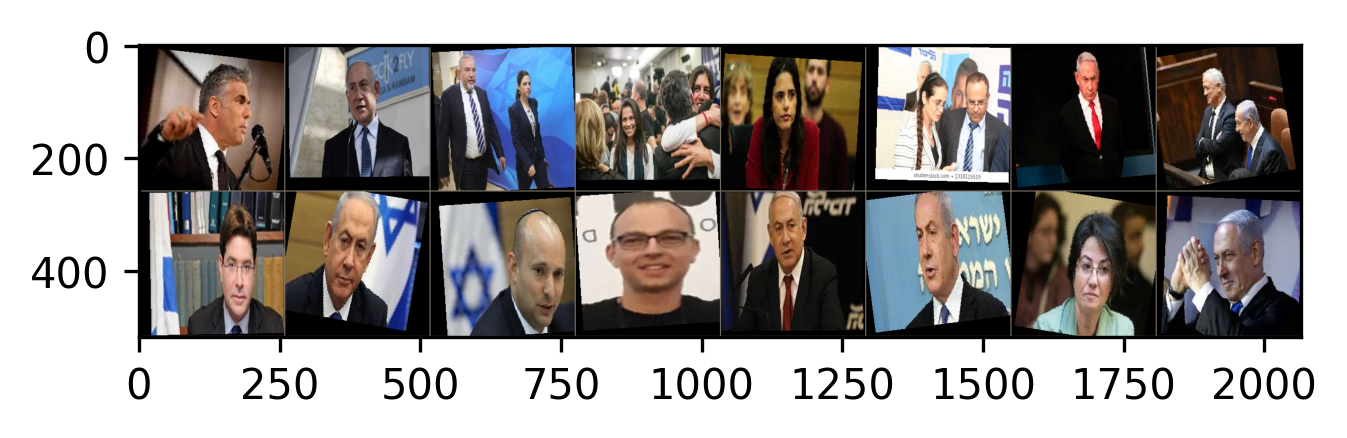

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8, )

imshow(out, "pt")

### 4. Load and setup pretrained model (VGG16 or ResNet152)

In [ ]:
# If needed, delete previously loaded model from memory
del model
gc.collect()

In [ ]:
# Load a pretrain VGG16 model with its weights
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 71.7MB/s]


In [ ]:
# Or load a pretrain ResNet152 model with its weights
model = models.resnet152(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 162MB/s]


In [ ]:
# Model structure
model

In [ ]:
# Model summary

summary(model.to(device), (3, 256, 256))

In [ ]:
# Define the number of input neurons in the final layer and
# replace the last layer with a linear layer with num_ftrs (4096) input features and 9 output features:

# Check fully connected layer if it is ResNet
if hasattr(model, 'fc'):
    last_layer = model.fc
    num_ftrs = last_layer.in_features

    model.fc = nn.Linear(in_features=num_ftrs, out_features=len(class_names))

# Check classifier layer if it is VGG
elif hasattr(model, 'classifier'):
    last_layer = model.classifier[-1]
    num_ftrs = last_layer.in_features

    model.classifier[-1] = nn.Linear(in_features=num_ftrs, out_features=len(class_names))

else:
    raise AttributeError("The model doesn't have 'fc' or 'classifier' attributes.")

# After this the model structure and summary can be checked

### 5. Define parameters and functions for finetuning the model.

In [ ]:
# Define loss, optimizer and other parameters

# If a GPU is available, make the model use it
model = model.to(device)
model_name = type(model).__name__

# For a multi-class problem CrossEntropyLoss() will be used as criterion
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate = 0.001 and momentum = 0.9
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# Number of epochs for training
num_epochs = 10

# Training strategies:
# 'finetuning' - all layers trainable (by default),
# 'half_freeze' - only last 50% layers trainable,
# 'threeQ_freeze' - only last 25% layers trainabel,
# 'feature_extraction' - only classifier head trainable
strategy = 'threeQ_freeze'

In [ ]:
# Function to choose training strategy

def apply_training_strategy(model, strategy):

    if strategy == 'feature_extraction':
        for param in model.parameters():
            param.requires_grad = False

        if hasattr(model, 'classifier'):
            for param in model.classifier.parameters():  # for VGG16
                param.requires_grad = True
        elif hasattr(model, 'fc'):
            for param in model.fc.parameters():  # for ResNet152
                param.requires_grad = True

    elif strategy == 'half_freeze':
        modules = list(model.children())
        num_modules = len(modules)
        freeze_up_to = num_modules // 2

        for idx, module in enumerate(modules):
            for param in module.parameters():
                param.requires_grad = idx >= freeze_up_to

    elif strategy == 'threeQ_freeze':
        modules = list(model.children())
        num_modules = len(modules)
        freeze_up_to = (num_modules * 3) // 4

        for idx, module in enumerate(modules):
            for param in module.parameters():
                param.requires_grad = idx >= freeze_up_to


    elif strategy == 'finetuning':
        for param in model.parameters():
            param.requires_grad = True

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

In [ ]:
# Function to train a model

def train_model(model, dataloaders, criterion, optimizer, scheduler, strategy='finetuning', num_epochs=25):
    since = time.time()

    # Apply training strategy to the model
    apply_training_strategy(model, strategy)

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Log dictionary

    log_data = {
    'train': {
        'epoch': [],
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        },
    'val': {
        'epoch': [],
        'loss': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        }
    }

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode.
                model.train()
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            running_preds = []
            running_labels = []

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # get class corresponding to max probability along rows (dim 1 - classes) for every item in a batch
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                running_preds.extend(preds.cpu().numpy())
                running_labels.extend(labels.cpu().numpy())

            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()

            # Epoch metrics and log dictionary
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().item() / dataset_sizes[phase]
            epoch_precision = precision_score(running_labels, running_preds, average='weighted')
            epoch_recall = recall_score(running_labels, running_preds, average='weighted')
            epoch_F1 = f1_score(running_labels, running_preds, average='weighted')

            log_data[phase]['epoch'].append(epoch)
            log_data[phase]['loss'].append(epoch_loss)
            log_data[phase]['accuracy'].append(epoch_acc)
            log_data[phase]['precision'].append(epoch_precision)
            log_data[phase]['recall'].append(epoch_recall)
            log_data[phase]['f1_score'].append(epoch_F1)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, log_data

### 6. Finetune the model




In [ ]:
# Train the model

model_finetuned, log_data = train_model(model,
                    dataloaders,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       strategy = strategy,
                       num_epochs=num_epochs)

###7. Evaluate: plot the finetuned model convergence for different experiments

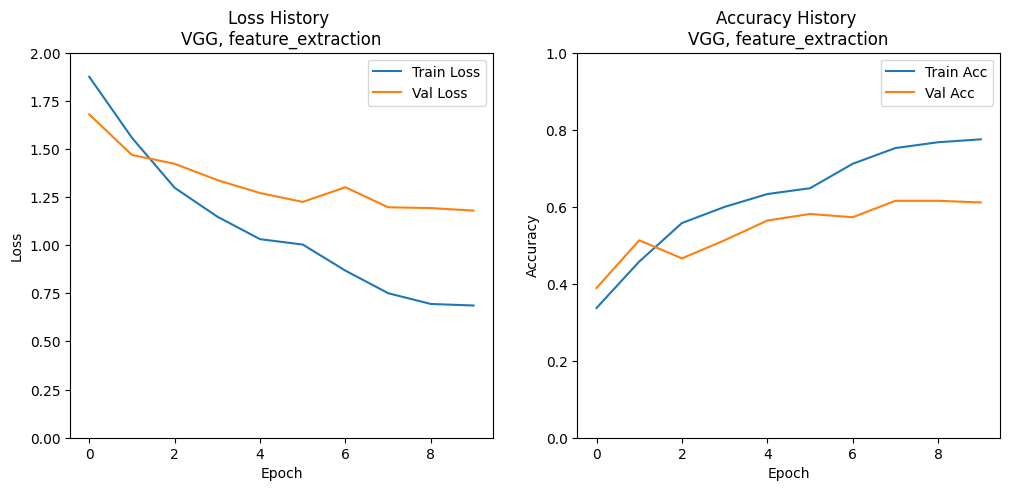

In [ ]:
# VGG16, strategy = 'feature_extraction'
# Plot loss and accuracy history

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(log_data['train']['loss'], label='Train Loss')
plt.plot(log_data['val']['loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title(f'Loss History \n{model_name}, {strategy}')
plt.ylim(0, 2)

plt.subplot(1, 2, 2)
plt.plot(log_data['train']['accuracy'], label='Train Acc')
plt.plot(log_data['val']['accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title(f'Accuracy History \n{model_name}, {strategy}')
plt.ylim(0, 1)

plt.show()

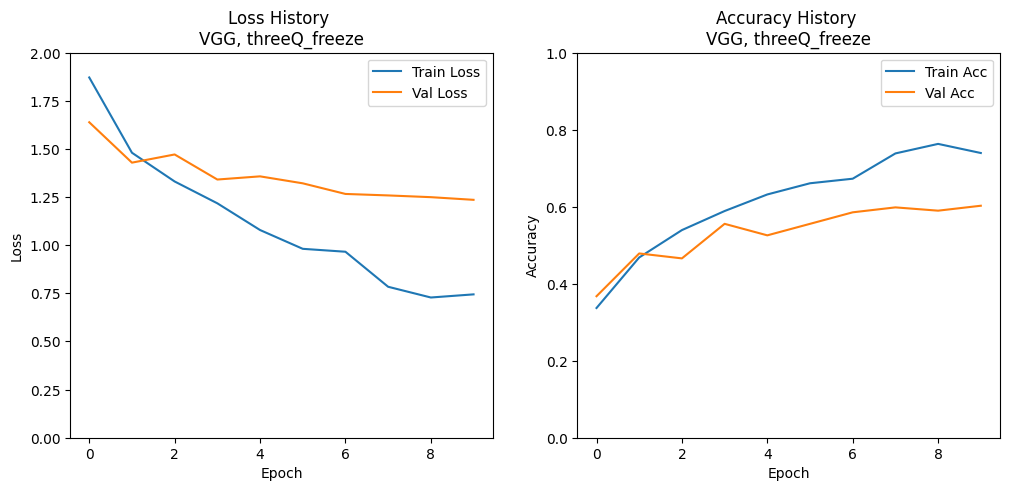

In [ ]:
# VGG16, strategy = 'threeQ_freeze'
# all other things being equal

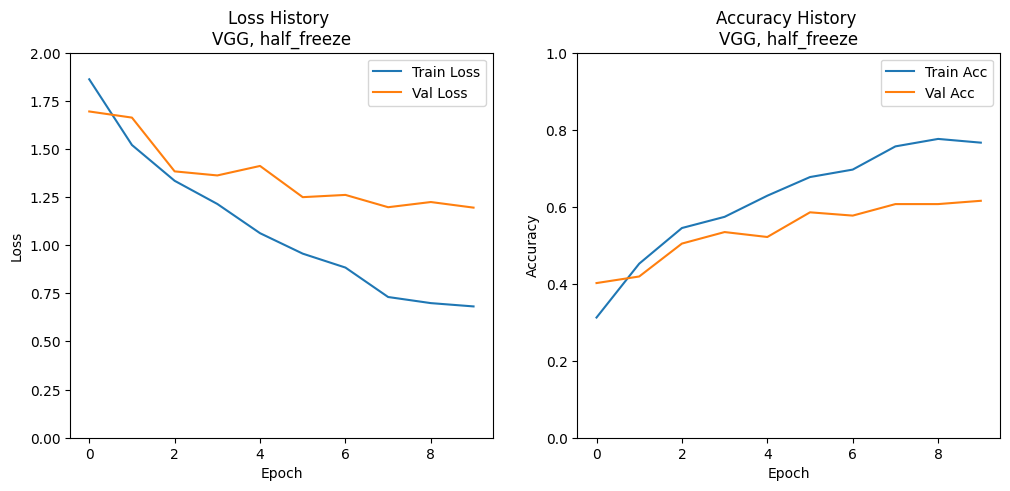

In [ ]:
# VGG16, strategy = 'half_freeze'
# all other things being equal

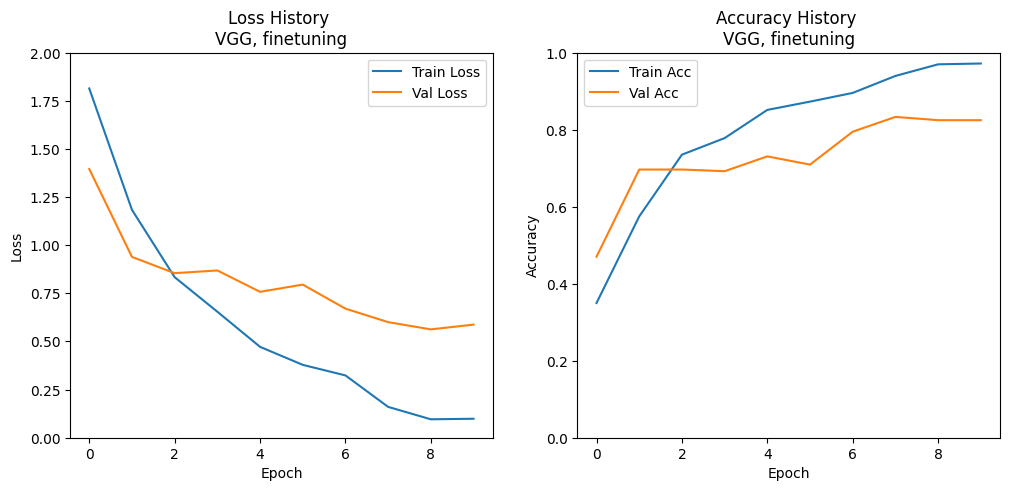

In [ ]:
# VGG16, strategy = 'finetuning'
# all other things being equal

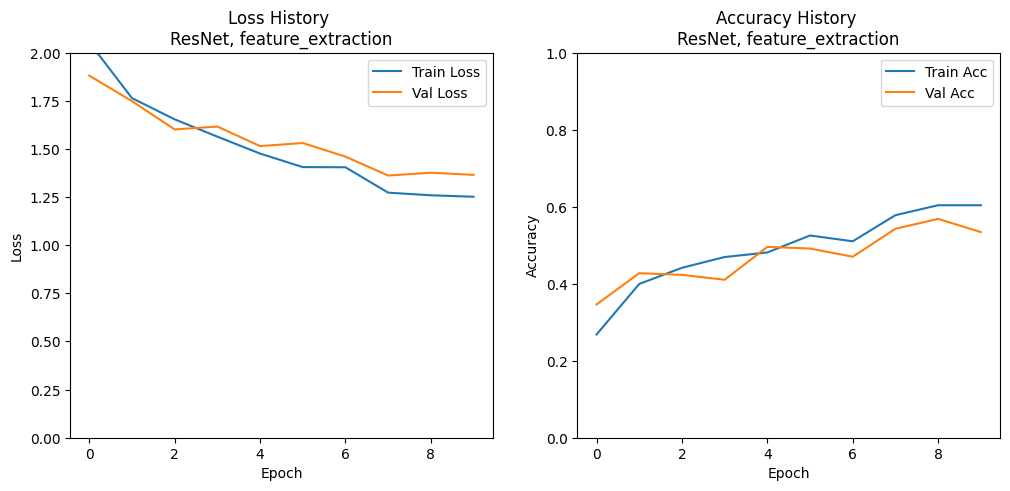

In [ ]:
# ResNet152, strategy = 'feature_extraction'
# all other things being equal

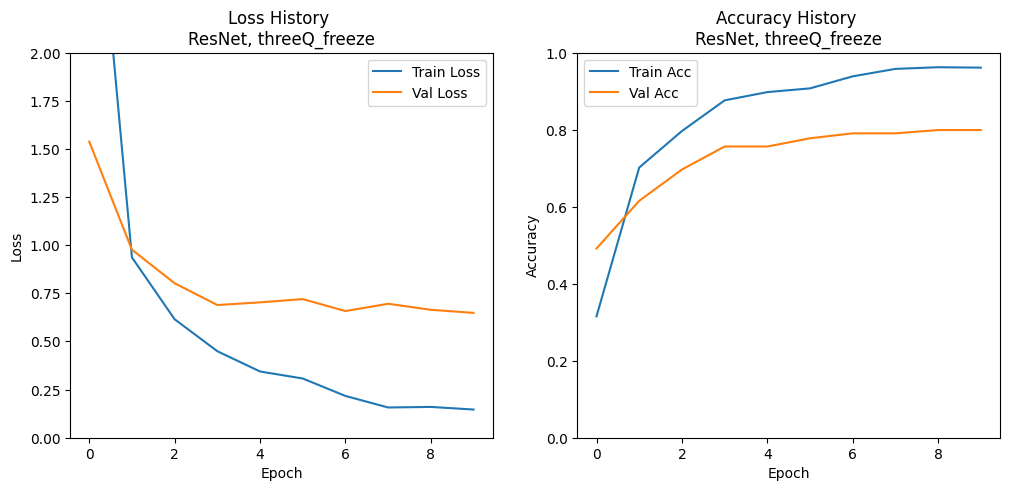

In [ ]:
# ResNet152, strategy = 'threeQ-freeze'
# all other things being equal

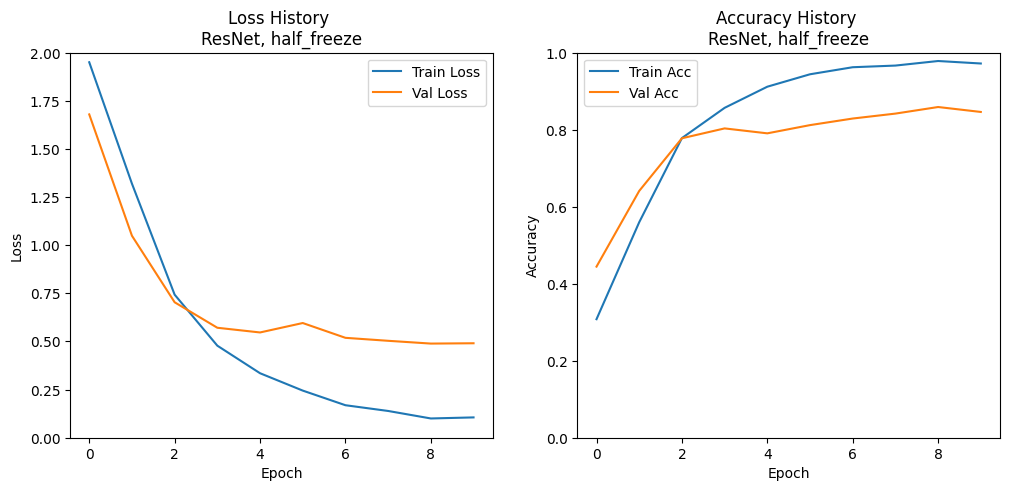

In [ ]:
# ResNet152, strategy = 'half-freeze'
# all other things being equal

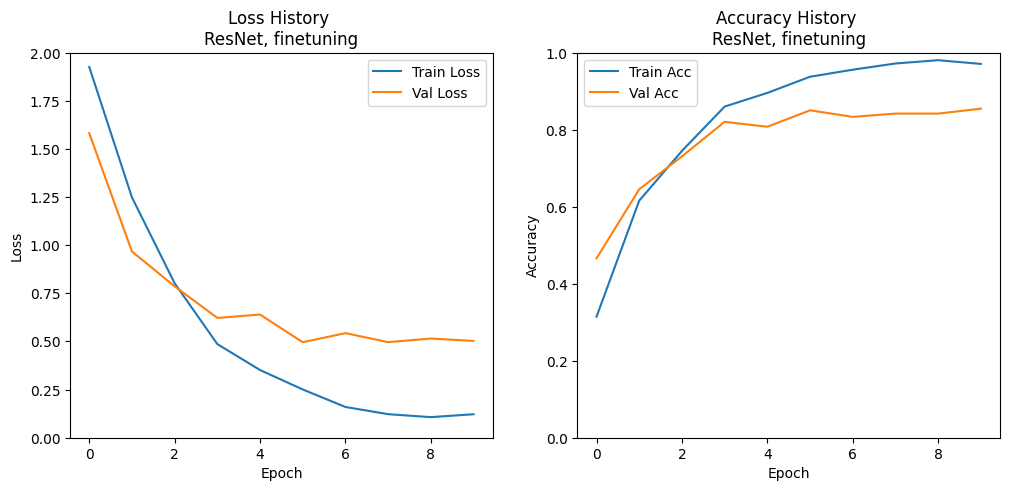

In [ ]:
# ResNet152, strategy = 'finetuning'
# all other things being equal

###8. Evaluate: get the finetuned model performance

In [ ]:
# Predict classes on the validation data

real_classes = []
predicted_classes = []

for inputs, labels in dataloaders['val']:
    # Prepare the inputs for GPU/CPU
    inputs = inputs.to(device)

    # Get predictions of model
    outputs = model_finetuned(inputs)
    #p_outputs = torch.nn.functional.softmax(outputs, dim=1).cpu().detach().numpy()
    predicted = torch.argmax(outputs, axis=1)

    # Collect predictions and real classes (labels)
    #real_classes.extend(labels.cpu().numpy())
    real_classes.extend(labels.numpy())
    predicted_classes.extend(predicted.cpu().numpy())

In [ ]:
# Get the classification report
print("Classification Report:\n")
print(classification_report(real_classes, predicted_classes))

# Get the confusion matrix
print("\nConfusion Matrix:\n")
print(confusion_matrix(real_classes, predicted_classes))

Classification Report:

              precision    recall  f1-score   support

           0       1.00      0.88      0.93        24
           1       0.83      0.86      0.85        58
           2       0.68      0.86      0.76        22
           3       0.89      0.77      0.83        22
           4       0.95      0.75      0.84        24
           5       0.33      0.33      0.33         3
           6       0.95      0.87      0.91        23
           7       0.80      0.94      0.86        34
           8       0.96      0.92      0.94        24

    accuracy                           0.85       234
   macro avg       0.82      0.80      0.81       234
weighted avg       0.87      0.85      0.86       234


Confusion Matrix:

[[21  1  1  0  0  0  1  0  0]
 [ 0 50  5  0  0  0  0  3  0]
 [ 0  1 19  0  1  0  0  1  0]
 [ 0  1  0 17  0  1  0  2  1]
 [ 0  2  0  2 18  0  0  2  0]
 [ 0  1  1  0  0  1  0  0  0]
 [ 0  2  1  0  0  0 20  0  0]
 [ 0  1  1  0  0  0  0 32  0]
 [ 0  1  0 

### 9. Error Analysis

In [ ]:
# The function to get a list of all errors in valuation data set

def get_errors(model, dataloaders, class_names, device):

    was_training = model.training
    model.eval()

    incorrect_images = []

    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)

            for j in range(inputs.size()[0]):
                if preds[j] != labels[j]:
                    incorrect_images.append((inputs.cpu().data[j], preds[j], labels[j], probs[j]))

        model.train(mode=was_training)
        return incorrect_images


In [ ]:
# The function to plot the top-10 error images and to get information about them

def top_incorrect_images(incorrect_images, top_n=10):

    sorted_images = sorted(incorrect_images, key=lambda x: max(x[3]), reverse=True)

    for i in range(min(top_n, len(sorted_images))):
        image, pred_class, true_class, probs = sorted_images[i]
        confidence = probs[pred_class]
        print(f"Image {i+1}: Predicted Class: {class_names[pred_class]}, True Class: {class_names[true_class]}, Confidence: {confidence:.4f}")
        imshow(image)


Image 1: Predicted Class: ofir_akunis, True Class: danny_danon, Confidence: 0.9988


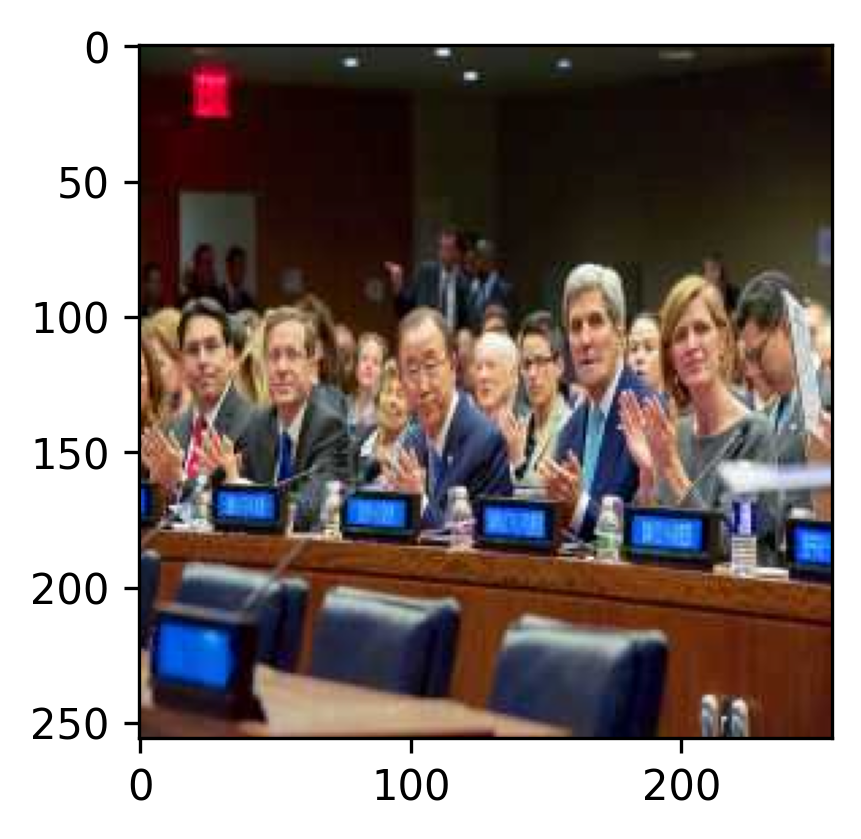

Image 2: Predicted Class: benjamin_netanyahu, True Class: benny_gantz, Confidence: 0.9843


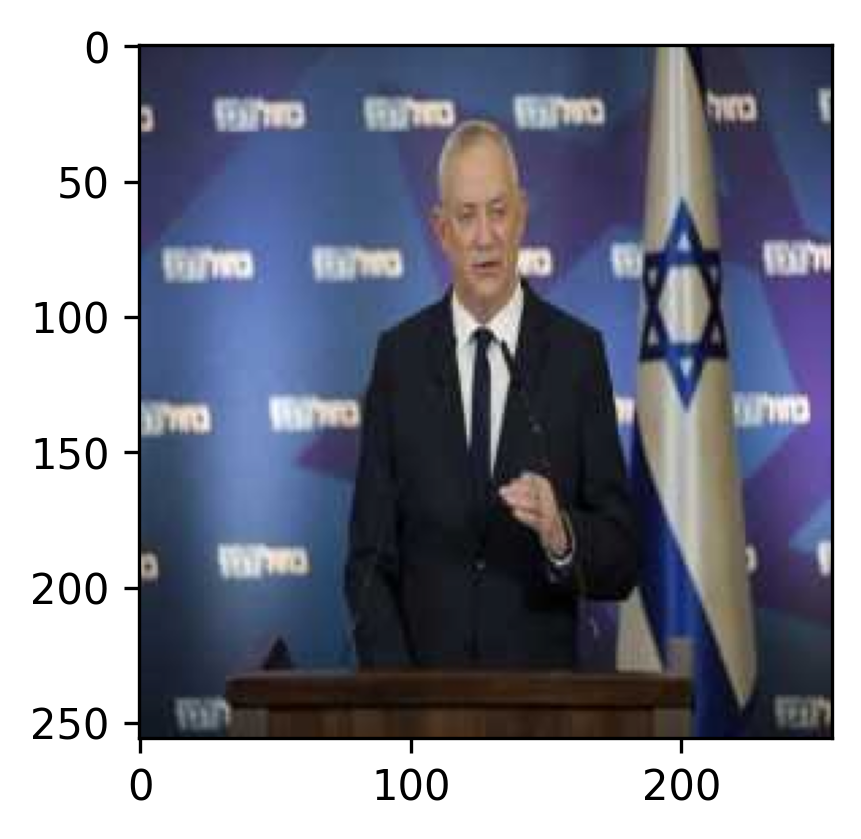

Image 3: Predicted Class: benjamin_netanyahu, True Class: gideon_saar, Confidence: 0.9275


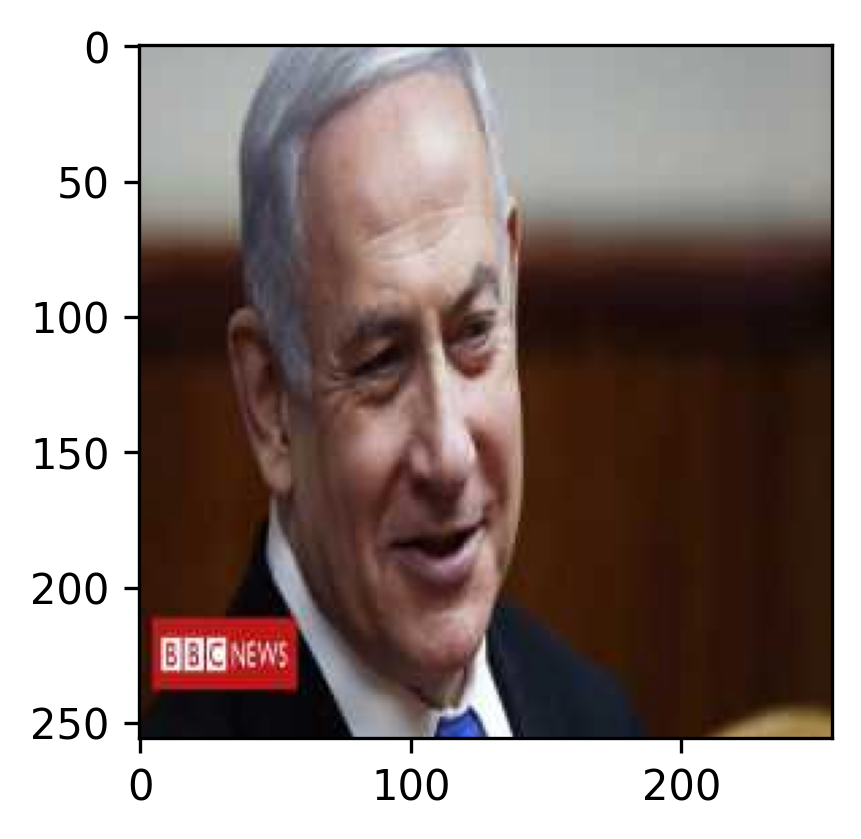

Image 4: Predicted Class: benny_gantz, True Class: benjamin_netanyahu, Confidence: 0.8810


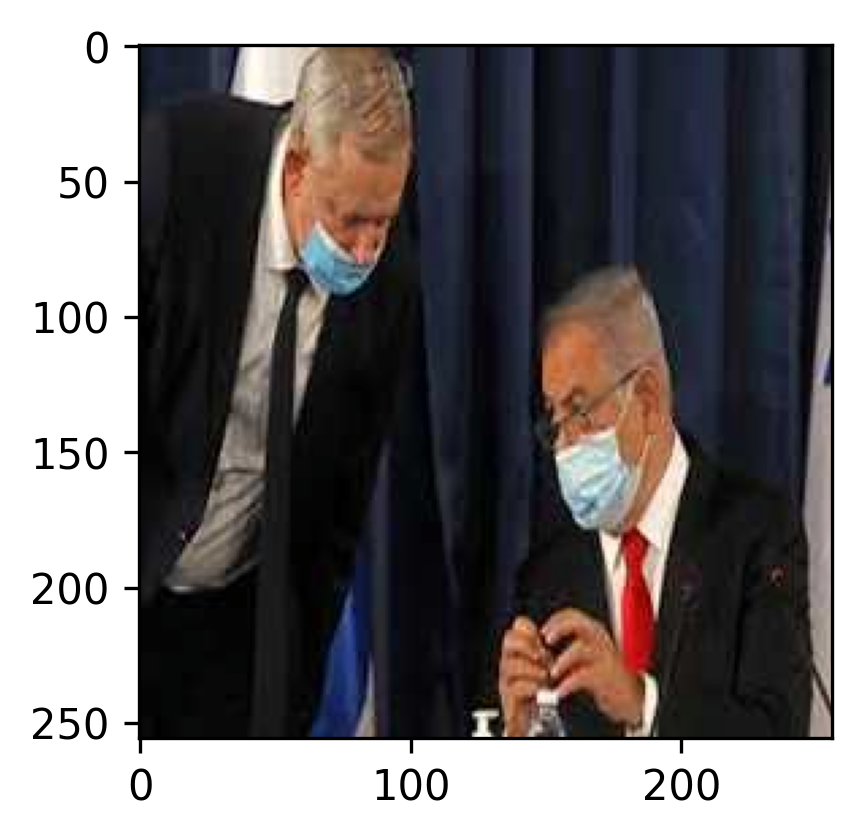

Image 5: Predicted Class: benjamin_netanyahu, True Class: gideon_saar, Confidence: 0.8518


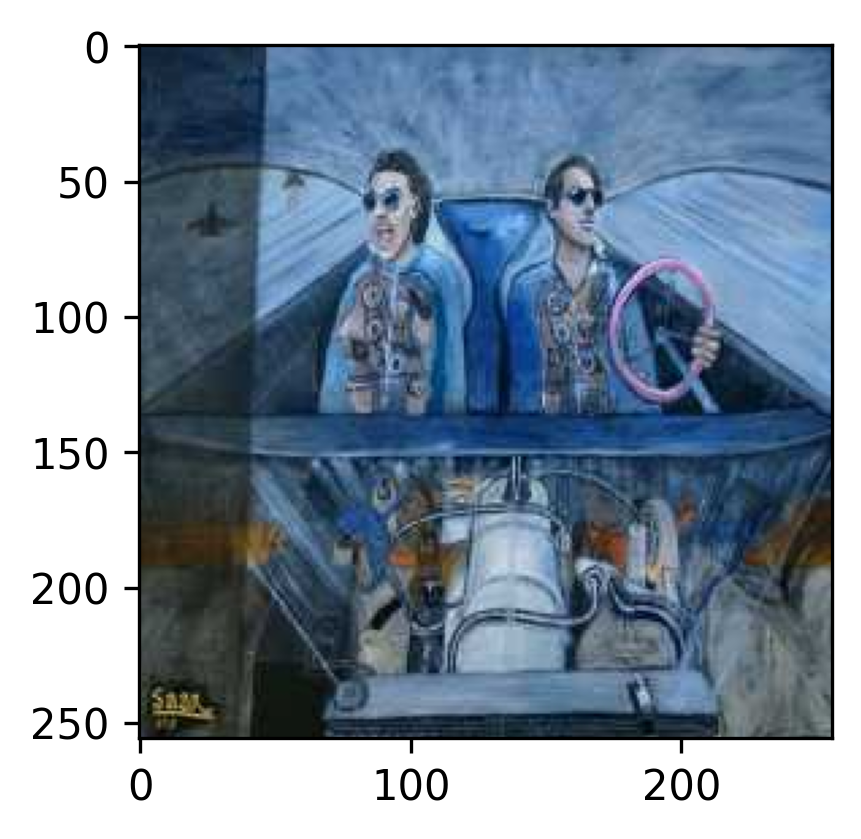

Image 6: Predicted Class: ofir_akunis, True Class: benjamin_netanyahu, Confidence: 0.7963


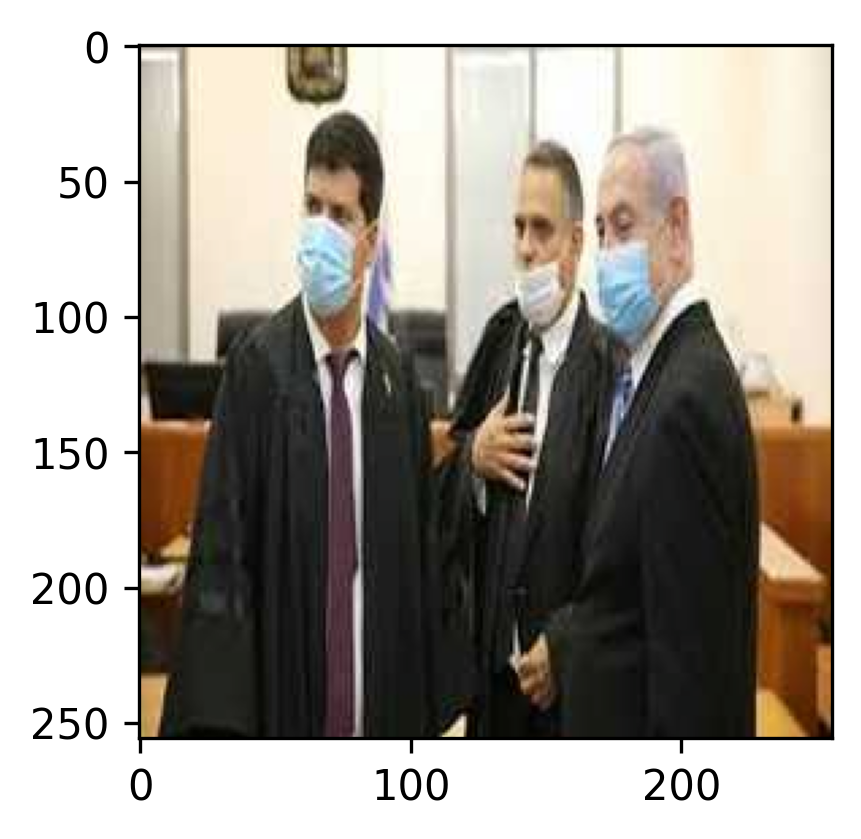

Image 7: Predicted Class: ofir_akunis, True Class: danny_danon, Confidence: 0.7814


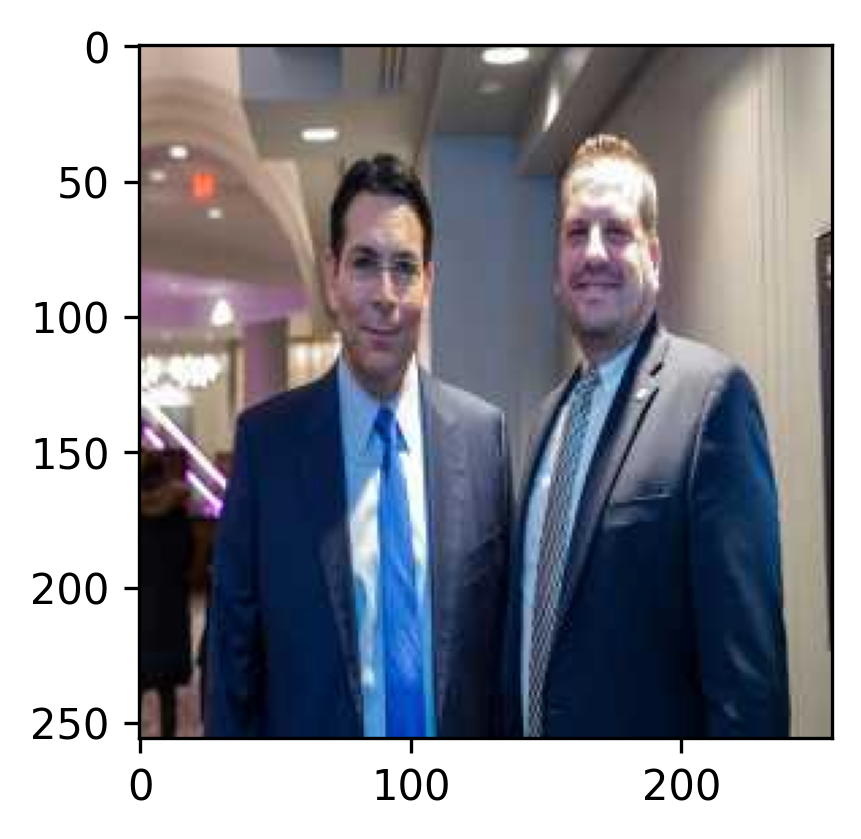

Image 8: Predicted Class: benjamin_netanyahu, True Class: ofir_akunis, Confidence: 0.7567


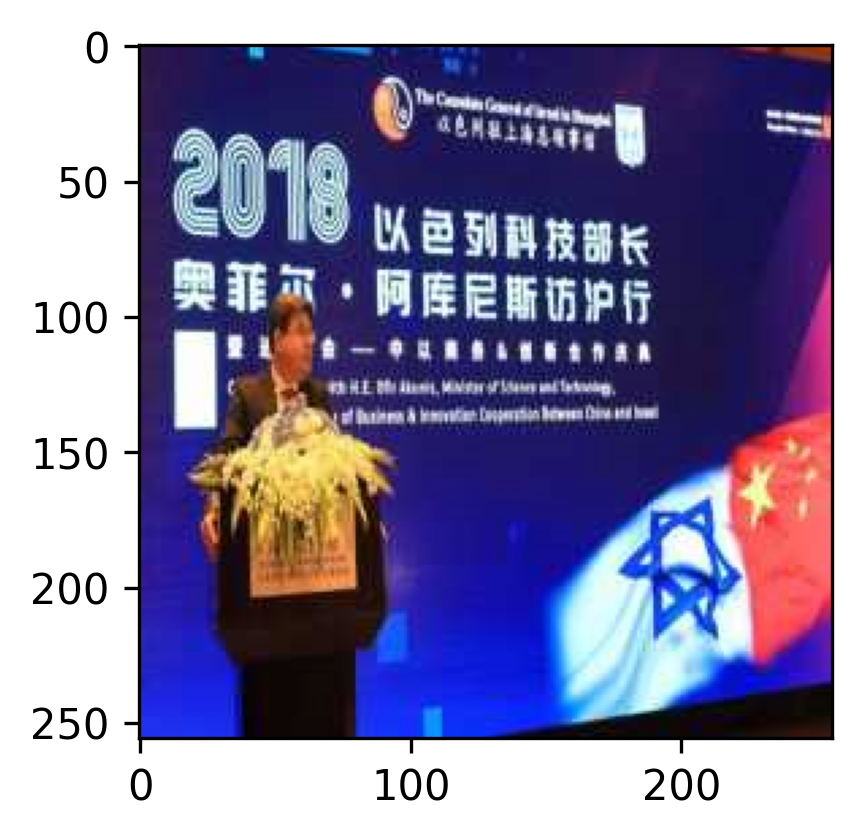

Image 9: Predicted Class: benny_gantz, True Class: ofir_akunis, Confidence: 0.6950


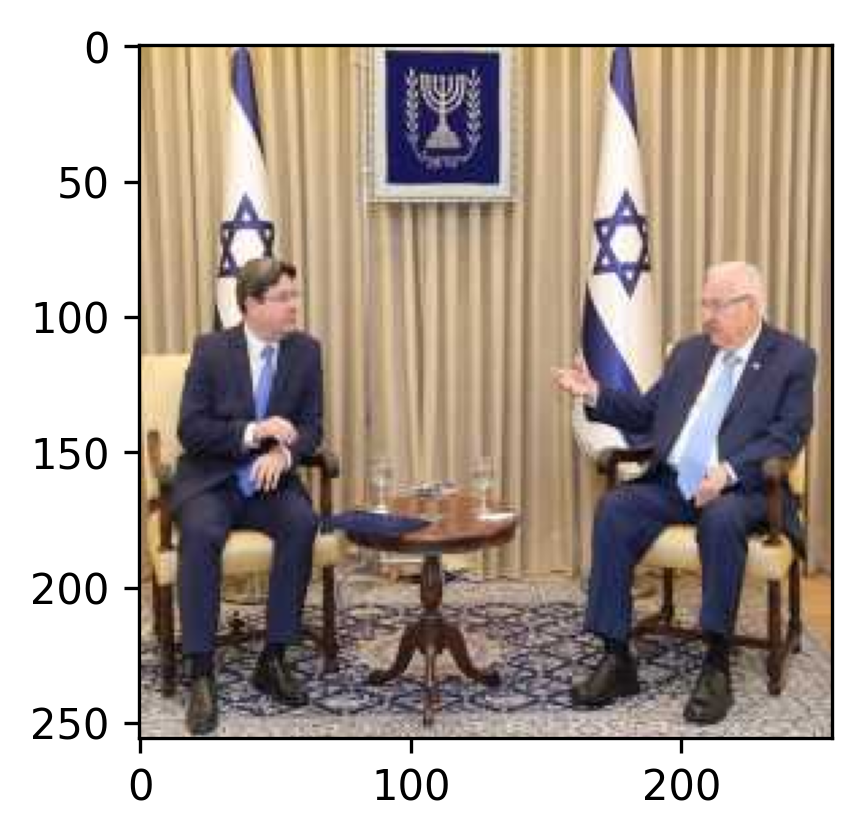

Image 10: Predicted Class: benny_gantz, True Class: benjamin_netanyahu, Confidence: 0.6788


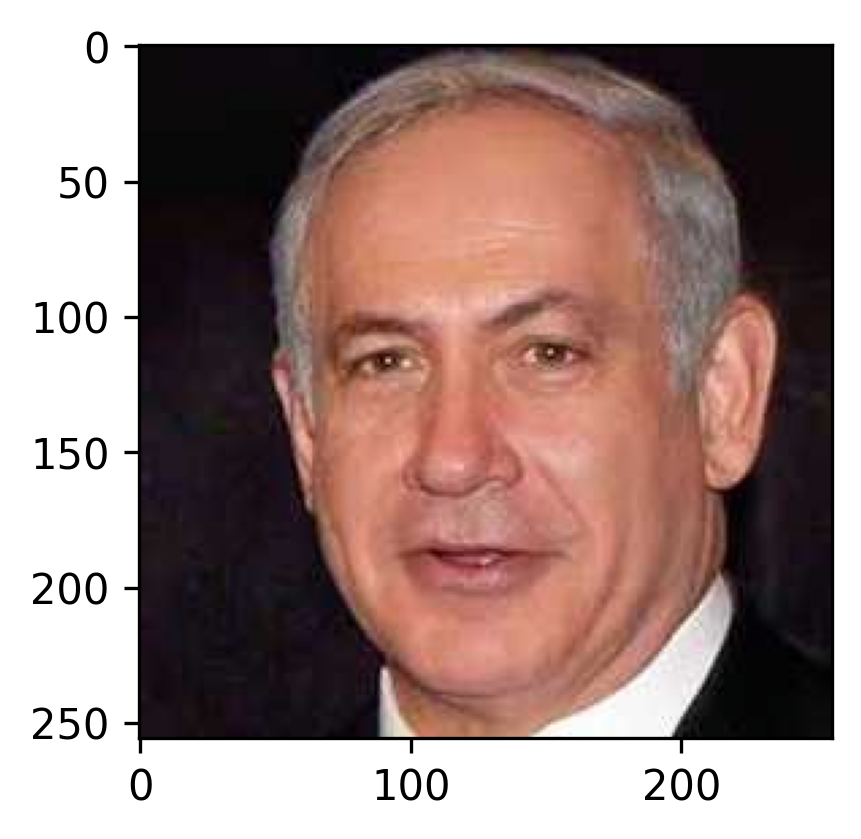

In [ ]:
# use top_incorrect_images to get top-10 errors

train_dataloader = dataloaders['val']
class_names = train_dataloader.dataset.classes

incorrect_images = get_errors(model_finetuned, dataloaders, class_names, device)
top_incorrect_images(incorrect_images)